In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from fbprophet import Prophet
from sklearn.metrics import r2_score

from obtaining_data import *

In [2]:
def choose_country(data_dir,country_name):
    print("...fetching data for", country_name)
    df = obtaining_data(data_dir)
    df = correct_datatype(df)
    df = df[df['country']== country_name]
    df = df.groupby(['date']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first'}).reset_index()
    df = df[(df['price']<=20000) & (df['price'] > 0 )]
    df = df[['price', 'date']]
    return df

In [3]:
data_dir = "/Users/mouadzeghraoui/Desktop/Capstone_Project/data/cs-train/"

In [4]:
df_UK = choose_country(data_dir,"United Kingdom")

...fetching data for United Kingdom


In [5]:
df_UK.head()

price       date
0  13281.12 2017-11-28
1  13222.97 2017-11-29
2  12941.50 2017-11-30
3   9163.07 2017-12-01
4   1263.28 2017-12-02

In [6]:
# Sort the dataframe by Date
df_UK.sort_values(by="date")

price       date
0    13281.12 2017-11-28
1    13222.97 2017-11-29
2    12941.50 2017-11-30
3     9163.07 2017-12-01
4     1263.28 2017-12-02
..        ...        ...
490   3378.21 2019-07-26
491   2656.70 2019-07-28
492   4124.82 2019-07-29
493  15260.12 2019-07-30
494   4844.04 2019-07-31

[472 rows x 2 columns]

In [7]:
# Function to plot interative plot plot
def interactive_plot(df,column_name,country_name,title):
    fig = px.line(title = title)
    fig.add_scatter(x = df.date,y = df[column_name], name = country_name )
    fig.show()

In [8]:
interactive_plot(df_UK,'price',"United Kingdom","Revenue")

In [9]:
# These are the column names expected by fbprophet
df_UK = df_UK[["date","price"]]

In [10]:
# These are the column names expected by fbprophet
df_UK.columns = ['ds','y']

In [11]:
df_UK.ds

0     2017-11-28
1     2017-11-29
2     2017-11-30
3     2017-12-01
4     2017-12-02
         ...    
490   2019-07-26
491   2019-07-28
492   2019-07-29
493   2019-07-30
494   2019-07-31
Name: ds, Length: 472, dtype: datetime64[ns]

In [12]:
# Split the data into testing and training datasets
train , test = df_UK[ df_UK['ds'] <= '2019-01-01'], df_UK[df_UK['ds'] >=  '2019-01-02']

## Modeling

In [16]:
model = Prophet()

In [17]:
# Create and fit the prophet model to the training data
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
# We are going to forecast for 31 days, so we get the dataframe contain dates which includes our training
# dates as well as 31 days into the future, for forecasting.
future = model.make_future_dataframe(periods = 30)

In [19]:
# Make prediction 
forecast = model.predict(future)
# 'yhat' is the mean predicted values and the 'yhat_lower' and 'yhat_upper' represent the lower and upper
# predicted boundaries

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds          yhat   yhat_lower    yhat_upper
327 2019-01-27   7841.385763  3929.755164  12246.586928
328 2019-01-28  10884.654238  7365.160585  14977.498792
329 2019-01-29  10297.353577  6104.680410  14286.923020
330 2019-01-30   9907.213150  5982.521637  13959.674147
331 2019-01-31  11206.020740  7457.646913  15131.039917

In [20]:
forecast = model.predict(future)

In [21]:
from fbprophet.plot import plot_plotly, plot_components_plotly

# Ploting the forecasted data

plot_plotly(model, forecast)

In [22]:
result = pd.merge(test, forecast, on='ds')

In [23]:
result

ds        y        trend   yhat_lower    yhat_upper  trend_lower  \
0  2019-01-03  6472.18  8735.325140  6555.688067  14431.220819  8735.325140   
1  2019-01-04  4793.46  8759.365695  5101.042241  13234.891701  8759.365695   
2  2019-01-06  3265.84  8807.446804  3438.235187  11282.268821  8806.721942   
3  2019-01-07  7129.17  8831.487359  6502.327943  14249.843106  8830.271967   
4  2019-01-08  4894.31  8855.527913  5870.313467  13582.817166  8853.493920   
5  2019-01-09  6943.44  8879.568468  5544.951937  13150.726583  8876.742895   
6  2019-01-10  5419.42  8903.609023  6579.967917  14626.828744  8900.164303   
7  2019-01-11  5904.01  8927.649578  5019.300457  13182.188490  8922.719475   
8  2019-01-13  1854.50  8975.730687  4070.974981  11403.351564  8968.273144   
9  2019-01-14  9302.67  8999.771242  6964.758327  14387.707317  8990.878665   
10 2019-01-15  6132.52  9023.811796  5953.494037  13894.365114  9013.483774   
11 2019-01-16  4142.04  9047.852351  5722.648976  13499.120581  9036.187679   
12 2019-01-17  7793.72  9071.892906  7008.759298  14848.840413  9058.585524   
13 2019-01-18  6388.74  9095.933460  5554.774649  13508.634356  9080.584109   
14 2019-01-20  2551.56  9144.014570  3440.645434  11675.940158  9124.941366   
15 2019-01-21  5831.54  9168.055124  6844.250457  14557.164147  9146.983228   
16 2019-01-22  6002.11  9192.095679  6277.866180  14095.645333  9169.874484   
17 2019-01-23  4654.76  9216.136234  5759.796012  13831.198071  9190.907556   
18 2019-01-24  4693.88  9240.176789  7215.943140  14847.095998  9213.201752   
19 2019-01-25  3465.64  9264.217343  5553.116116  13359.400266  9235.335174   
20 2019-01-27  2321.72  9312.298453  3782.035790  11636.622909  9279.134155   
21 2019-01-28  5485.02  9336.339007  7006.845448  14785.442563  9300.971893   
22 2019-01-29  5015.74  9360.379562  6458.660736  14212.768196  9322.882300   
23 2019-01-30  5740.00  9384.420117  6101.883064  14022.219631  9344.751414   
24 2019-01-31  3151.92  9408.460671  7528.843154  15522.526876  9366.893850   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   8735.325140     1797.560069           1797.560069           1797.560069   
1   8759.366296      266.493126            266.493126            266.493126   
2   8808.079709    -1470.912690          -1470.912690          -1470.912690   
3   8832.746515     1548.315231           1548.315231           1548.315231   
4   8857.766080      936.974015            936.974015            936.974015   
5   8882.600094      522.793034            522.793034            522.793034   
6   8907.444896     1797.560069           1797.560069           1797.560069   
7   8932.683279      266.493126            266.493126            266.493126   
8   8983.117311    -1470.912690          -1470.912690          -1470.912690   
9   9008.104954     1548.315231           1548.315231           1548.315231   
10  9033.509318      936.974015            936.974015            936.974015   
11  9058.665788      522.793034            522.793034            522.793034   
12  9083.985905     1797.560069           1797.560069           1797.560069   
13  9109.261877      266.493126            266.493126            266.493126   
14  9160.683019    -1470.912690          -1470.912690          -1470.912690   
15  9186.813761     1548.315231           1548.315231           1548.315231   
16  9212.183654      936.974015            936.974015            936.974015   
17  9237.322426      522.793034            522.793034            522.793034   
18  9263.597598     1797.560069           1797.560069           1797.560069   
19  9289.027624      266.493126            266.493126            266.493126   
20  9340.683012    -1470.912690          -1470.912690          -1470.912690   
21  9366.888251     1548.315231           1548.315231           1548.315231   
22  9393.107717      936.974015            936.974015            936.974015   
23  9418.765745      522.793034            522.793034       

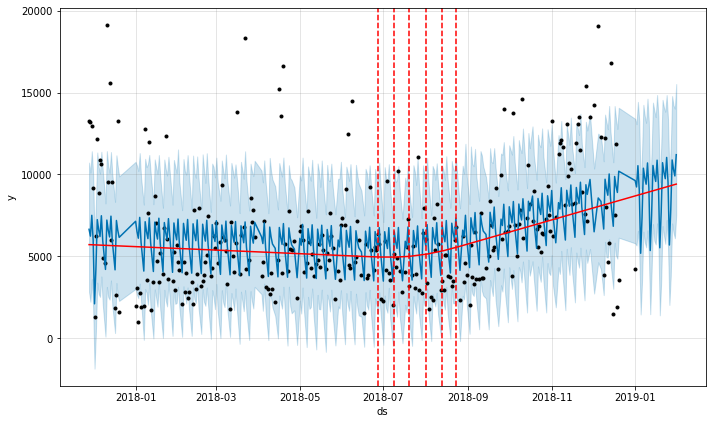

In [24]:
from fbprophet.plot import add_changepoints_to_plot

# This particular feature helps us identify trend changes that are infered by the model

fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)


In [25]:

from fbprophet import Prophet
from fbprophet.plot import plot_cross_validation_metric 
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2018-02-05 00:00:00 and 2018-11-02 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2018-02-05 00:00:00 and 2018-11-02 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2018-02-05 00:00:00 and 2018-11-02 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2018-02-05 00:00:00 and 2018-11-02 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2018-02-05 00:00:00 and 2018-11-02 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

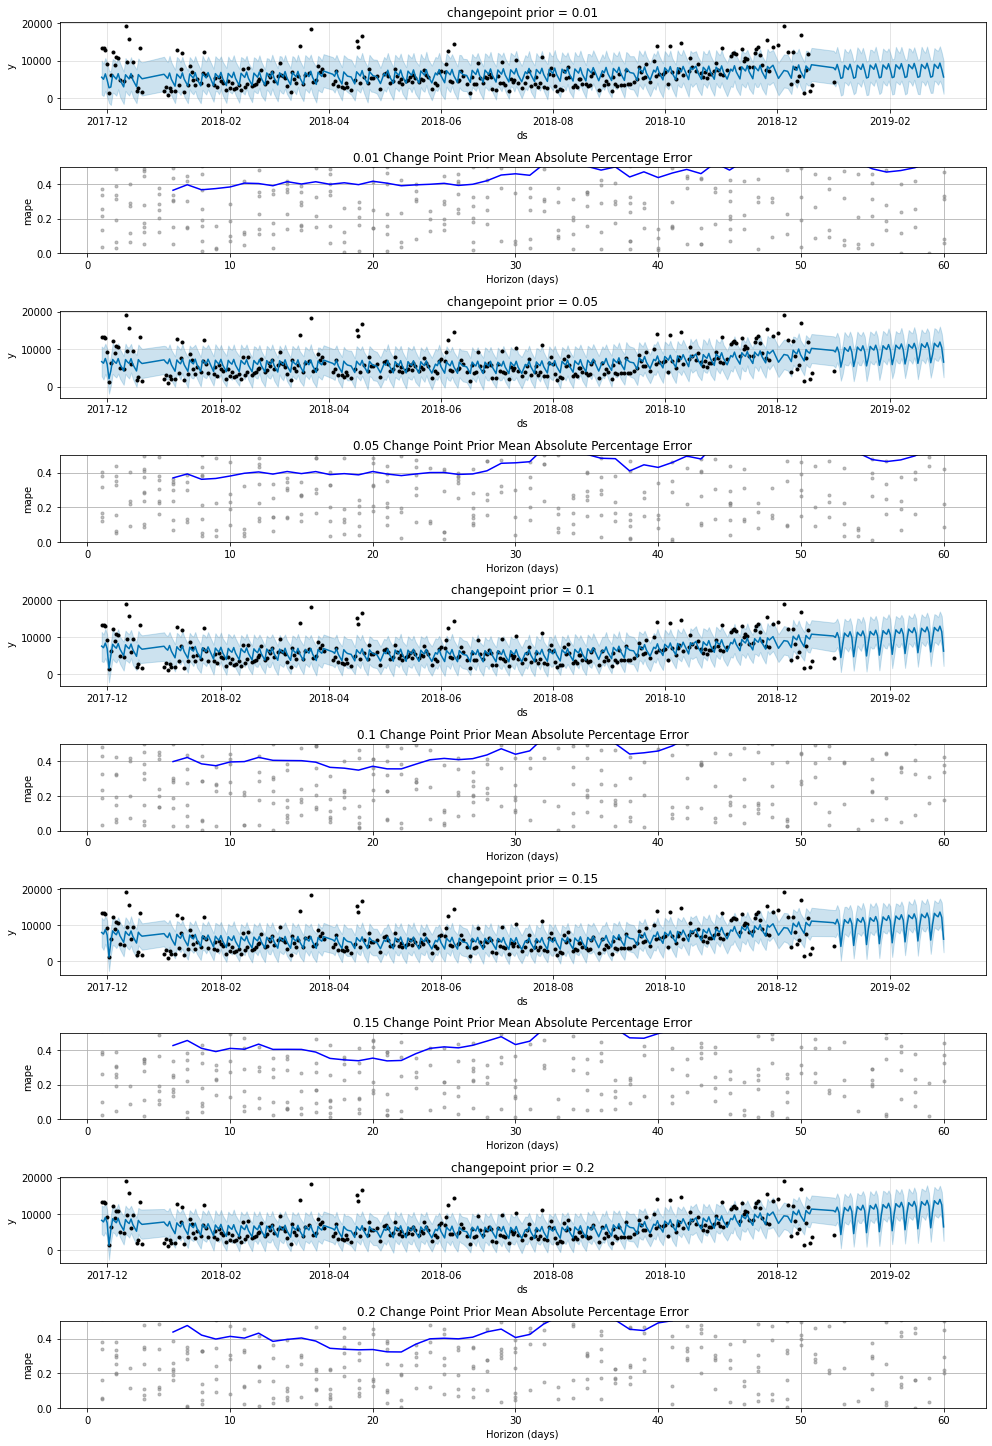

In [26]:
fig, ax = plt.subplots(10,1, figsize = (14, 20))
ax = ax.ravel()
j = 0
for i in [0.01, 0.05, 0.10, 0.15, 0.20]:
    m = Prophet(changepoint_prior_scale=i)
    #fit the prophet model on the data
    m.fit(train)
    # make a dataframe of the next two years 
    future = m.make_future_dataframe(periods=60)
    #predict on this future dataframe
    forecast = m.predict(future)
    # plot the forecast 
    fig = m.plot(forecast, ax = ax[j])
    ax[j].set_title('changepoint prior = ' + str(i))
    j += 1
    df_cv = cross_validation(m, initial='60 days', period='30 days', horizon = '60 days')
    df_p = performance_metrics(df_cv)
    fig = plot_cross_validation_metric(df_cv, metric='mape', ax = ax[j])
    ax[j].set_title(str(str(i) + ' Change Point Prior Mean Absolute Percentage Error'))
    ax[j].set_ylim(0,0.5)
    j += 1